In [2]:
from tqdm import tqdm
import datetime
tqdm.pandas()

import pandas as pd
import numpy as np
#connect local PATH
from matplotlib import pyplot as plt

import os 
import sys
p = os.path.abspath(r'C:\Users\Ben\Desktop\Diplomatiki')
sys.path.append(str(p))
from CryptoSent.tools.crypto_coin_actual import get_btc_actual_hourly
from CryptoSent.tools import evaluation as eval
from CryptoSent.tools.utils import load_submissions

from sklearn.preprocessing import MinMaxScaler

def errors(x,Y):
    return [Y[i]-x[i] for i in range(len(x))]

def abolute_errors(x,Y):
    return [abs(Y[i]-x[i]) for i in range(len(x))]

    
def mean_error(x,Y):
    return np.mean([Y[i]-x[i] for i in range(len(x))])

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as r2  
from sklearn.metrics import mean_squared_error as mse   #squared=False:rmse
#from sklearn.metrics import mean_squared_log_error as msle      #squared=False:rmsle

from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.linear_model import TweedieRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import itertools

evaluation_metrics=[mean_error,mae,mape,mse]
evaluation_metrics_names=['me','mae','mape','mse','rmse',]
def evaluate_pred(x,Y,model_name='m1'):
    scores=[]
    for metric in evaluation_metrics:
        scores.append(metric(x,Y))
    scores.append(mse(x,Y,squared=False))
    output=pd.DataFrame(
        np.array(scores),
        index=evaluation_metrics_names,
        columns=[model_name])
    return output



# import datasets
#subs=load_submissions()
btc=get_btc_actual_hourly().sort_index()
btc['perc']=btc.close.pct_change()
btc['difference']=btc.close.diff()
#btc=btc[['close','perc','difference']]
btc=btc.dropna()
subs=load_submissions()
subs['volume']=1

100%|██████████| 30907/30907 [00:00<00:00, 158725.52it/s]


# Stationarity

In [3]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
result = adfuller(btc.perc.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


def ts_split(ts,train_window=24,test_window=1,test_lenght=24*7,verbose=True):
    x=[]
    y=[]
    for i in range(len(ts)-train_window):
        x.append(ts[i:train_window+i])
        y.append(ts[train_window+i:train_window+i+test_window])
    x=np.array(x).reshape(len(x),train_window)
    y=np.array(y).reshape(len(y),test_window)

    xt,xv=x[:-test_lenght],x[-test_lenght:]
    yt,yv=y[:-test_lenght],y[-test_lenght:]

    if verbose:
        print('base size:',x.shape)
        print('xt size:',xt.shape)
        print('yt  size:',yt.shape)
        print('xv size:',xv.shape)
        print('yv size:',yv.shape)
        print('validity check: ',xt.shape[0],'+',xv.shape[0],'=',xt.shape[0]+xv.shape[0])

    return xt,yt,xv,yv

ADF Statistic: -24.983809776287387
p-value: 0.0
Critial Values:
   1%, -3.4305619541115524
Critial Values:
   5%, -2.8616336780834404
Critial Values:
   10%, -2.5668198619685216


# With Sentiment

,knn
me,1.009466
mae,5.208947
mape,4.489040
mse,0.430906
rmse,6.564342


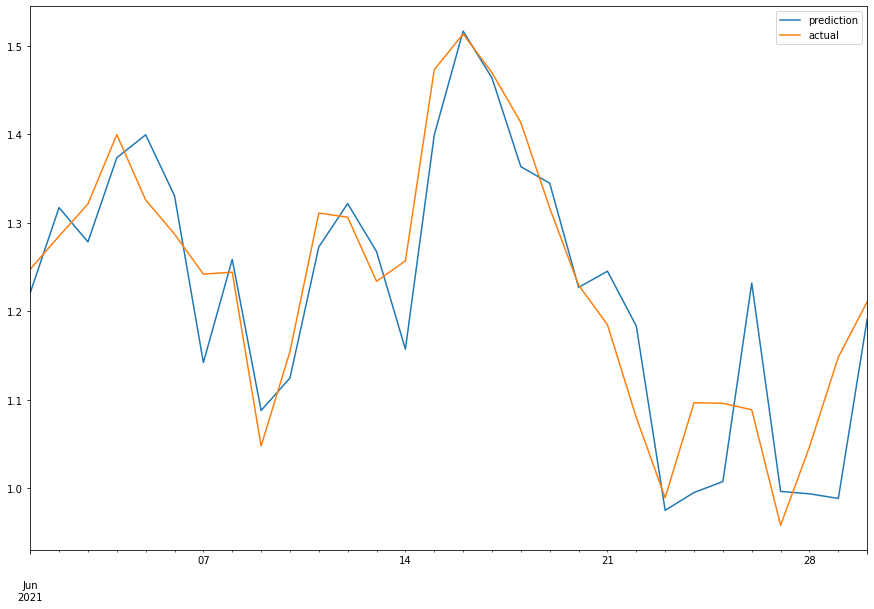

In [144]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scl=StandardScaler()


resample_period='d'
TARGET='close'

#filter df
sentiment_signals=['sell', 'buy', #'sent_ntusd',
'sent_ntusd_wavg', #'sent_ntusd_coms',
'sent_ntusd_coms_wavg', 'sent_lr',
'sent_lr_coms', 'sent_db', 'sent_fb', 'sent_fbt', 'sent_dbe_sadness',
'sent_dbe_joy', 'sent_dbe_love', 'sent_dbe_anger', 'sent_dbe_fear',
'sent_dbe_surprise']

#filter on sentiment signals, topic and any other
v_topic=subs.topic=='Bitcoin'
v_score=subs.origin!='main'

v_awards=subs.awards_value > subs.awards_value.quantile(.99)
v_awards_resample=subs.resample(resample_period).awards_value.transform(lambda x: x>x.quantile(.90))

v_karma=subs.author_karma > subs.author_karma.quantile(.90)
v_karma_resample=subs.resample(resample_period).author_karma.transform(lambda x: x>x.quantile(.90))

filtered_df=subs[v_topic][sentiment_signals]

# & (v_score |v_awards |v_karma)
#filter on btc features
btc_fts=['unix', 'date', 'symbol', 'open','close', 'high', 'low', 'close', 'Volume BTC',
       'Volume USD', 'avg_hl', 'avg_oc', 'perc', 'difference']
btc_filtered=btc.drop(columns=['unix','date','symbol','avg_hl','avg_oc'])



maindf=pd.concat([
    btc_filtered.resample(resample_period).mean(),
    filtered_df.resample(resample_period).mean(),
    subs[v_topic].resample(resample_period).volume.sum()],axis=1).dropna().head(-1)




dft=pd.DataFrame(
    scl.fit_transform(maindf),
    columns=maindf.columns,
    index=maindf.index)

#dft=pd.DataFrame(
#    scl.fit_transform(maindf.drop(columns=[TARGET])),
#    columns=maindf.drop(columns=[TARGET]).columns,
#    index=maindf.drop(columns=[TARGET]).index)[:'2021-06']


target=dft[TARGET]
#features=dft.drop(columns=[TARGET])
#features=dft[['open','high','low','sent_fbt']]
features=dft#[['high','difference','buy','sent_lr_coms','volume']]
dt_index=dft.index
featuresnp=features.to_numpy()
targetnp=target.to_numpy()

count=0
train_window=4
test_window=1
test_lenght=30*1*1
x=[]
y=[]
for i in range(target.shape[0]-train_window-test_window):
    x.append(featuresnp[i:train_window+i])
    y.append(targetnp[train_window+i:train_window+i+test_window])

x=np.array(x)
y=np.array(y)
x=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
y=y.reshape(y.shape[0],)
xt,xv=x[:-test_lenght],x[-test_lenght:]
yt,yv=y[:-test_lenght],y[-test_lenght:]

# Or better yet: use a pipeline!


#model=RandomForestRegressor(n_estimators=5,max_depth=30, random_state=0)
#model=DecisionTreeRegressor()
model=linear_model.LinearRegression()
#model=KNeighborsRegressor()


model.fit(xt,yt)
pred=model.predict(xv)
res=pd.concat(
    [
    pd.DataFrame(
        pred,
        columns=['prediction'],
        index=dt_index[-len(pred):]
        ),
    pd.DataFrame(
        yv,
        columns=['actual'],
        index=dt_index[-len(pred):]
        )
    ]
    ,axis=1)
res.plot(figsize=(15,10));
evaluate_pred(res['prediction'],res['actual'],model_name='knn')*100

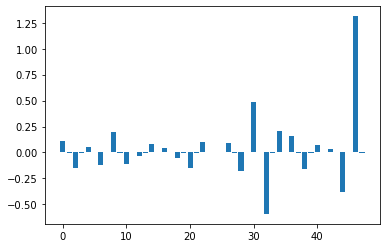

In [24]:
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	#print('Feature: %0d, Score: %.5f' % (i,v))
	pass
# plot feature importance

plt.bar([x for x in range(len(importance))], importance)
plt.show()

,knn
me,-0.514512
mae,3.072662
mape,7.622224
mse,0.368725
rmse,6.072271


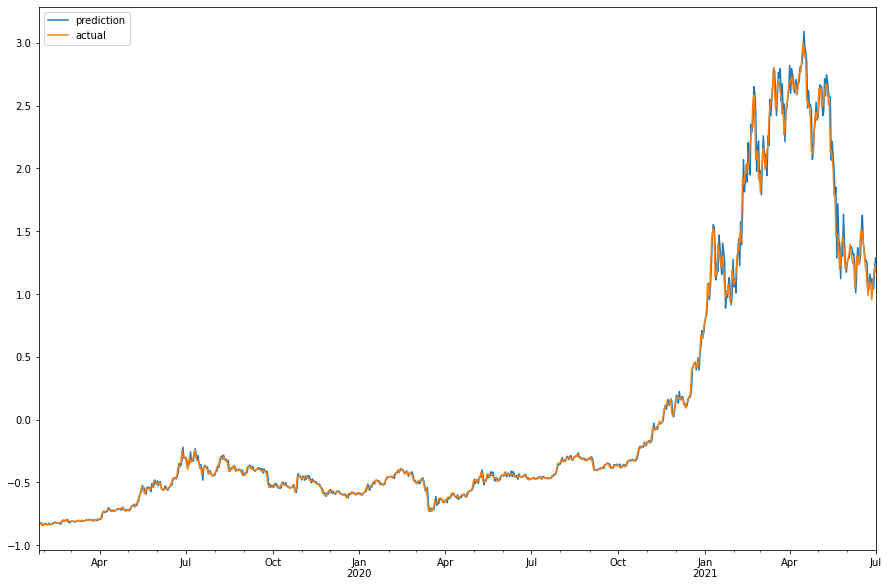

In [6]:
pred=model.predict(x)
res=pd.concat(
    [
    pd.DataFrame(
        pred,
        columns=['prediction'],
        index=dt_index[-len(pred):]
        ),
    pd.DataFrame(
        y,
        columns=['actual'],
        index=dt_index[-len(pred):]
        )
    ]
    ,axis=1)
res.plot(figsize=(15,10));
evaluate_pred(res['prediction'],res['actual'],model_name='knn')*100

In [7]:
eval.get_granger_causality(res)

,Y_actual__X_prediction,Y_prediction__X_actual
0,0.0000,0.0
1,0.0001,0.0
2,0.0000,0.0
3,0.0000,0.0


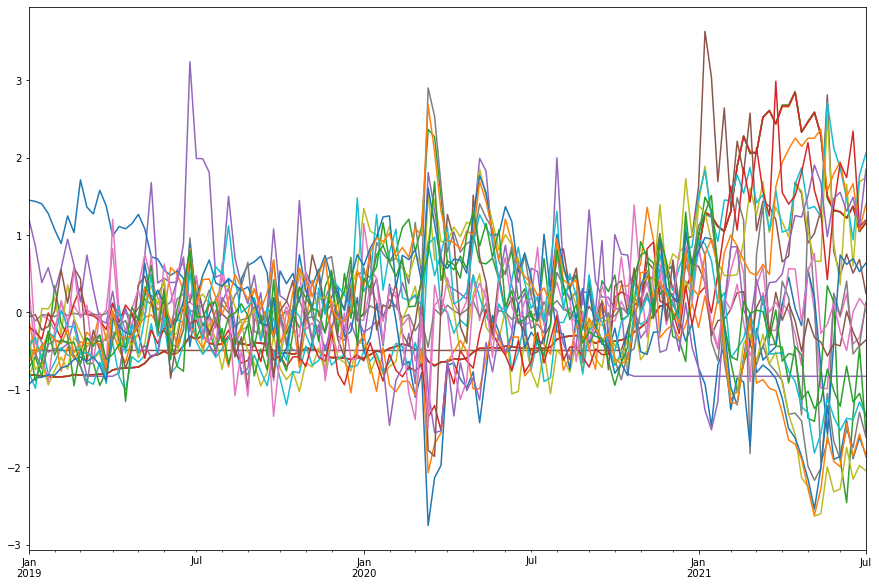

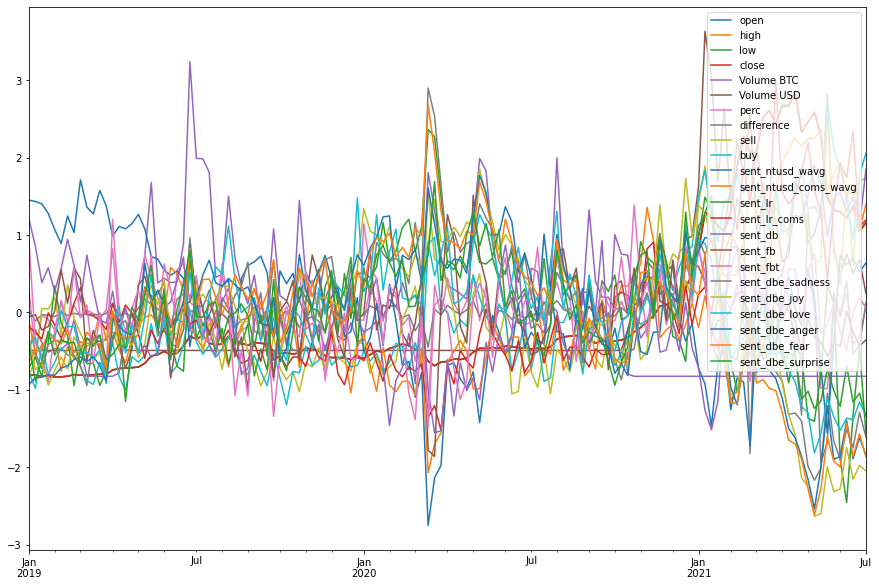

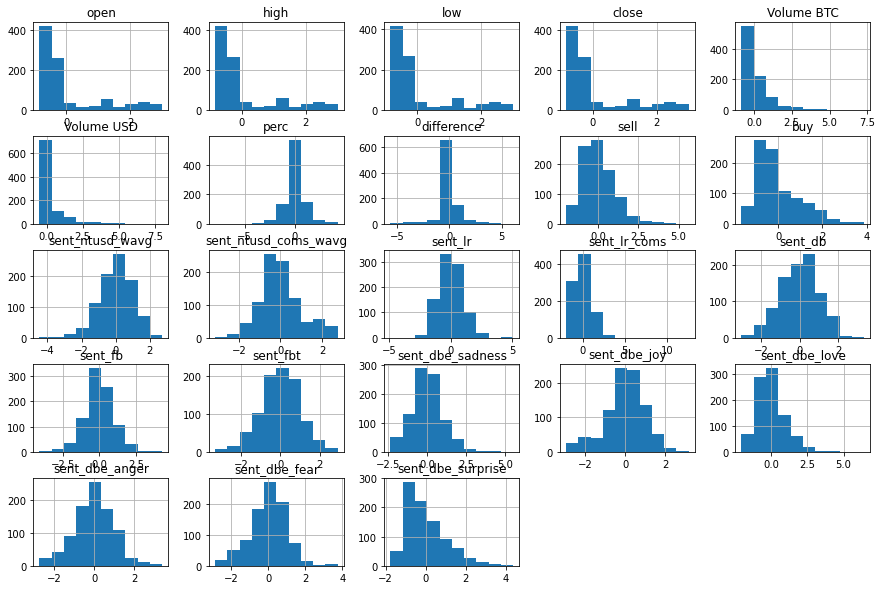

In [9]:
import plotly.express as px
import xarray as xr

fig = px.imshow(dft.resample('w').mean().corr(), color_continuous_scale='RdBu_r', origin='lower')
fig.show()


dft.resample('w').mean().plot(figsize=(15,10),legend=False)
dft.resample('w').mean().plot(figsize=(15,10));
dft.resample('d').mean().hist(figsize=(15,10));

In [10]:
subs.iloc[22:23].resample('h').mean()

,num_comments,score,subreddit_subscribers,author_karma,awards_value,author_posts,sell,buy,sent_ntusd,sent_ntusd_wavg,...,sent_lr_coms,sent_db,sent_fb,sent_fbt,sent_dbe_sadness,sent_dbe_joy,sent_dbe_love,sent_dbe_anger,sent_dbe_fear,sent_dbe_surprise
created,,,,,,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,6.0,17.0,157488.0,NaN,0.0,1.0,0.0,0.0,38.759897,0.461427,...,0.792539,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


# Loopa


In [96]:
TARGET='close'
target=dft[TARGET]
#features=dft.drop(columns=[TARGET])
res_save=[]
eval_save=[]
dt_index=dft.index
predictions=pd.DataFrame()
eval_res=pd.DataFrame()

#for col in dft.columns:
for combination in range(3):
    #for i in itertools.combinations(dft.drop(columns=[ 'high', 'low', 'Volume BTC', 'Volume USD', 'perc','difference']).columns,combination+1):
    for i in itertools.combinations(dft[sentiment_signals].columns,combination+1):
        col_name=''
        for z in i:col_name+=z+'_'

        features=dft[list(i)]

        featuresnp=features.to_numpy()
        targetnp=target.to_numpy()

        count=0
        train_window=24
        test_window=1
        test_lenght=24*7*1
        x=[]
        y=[]
        for i in range(target.shape[0]-train_window-test_window):
            x.append(featuresnp[i:train_window+i])
            y.append(targetnp[train_window+i:train_window+i+test_window])

        x=np.array(x)
        y=np.array(y)
        x=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
        y=y.reshape(y.shape[0],)
        xt,xv=x[:-test_lenght],x[-test_lenght:]
        yt,yv=y[:-test_lenght],y[-test_lenght:]

        # Or better yet: use a pipeline!

        model=linear_model.LinearRegression()

        model.fit(xt,yt)
        pred=model.predict(xt)
        res=pd.concat(
            [
            pd.DataFrame(
                pred,
                columns=[f'pred__{col_name}'],
                index=dt_index[-len(pred):]
                ),
            pd.DataFrame(
                yt,
                columns=['actual'],
                index=dt_index[-len(pred):]
                )
            ]
            ,axis=1)
        #res.plot(figsize=(15,10));
        predictions=pd.concat([res,predictions],axis=1)
        evl=evaluate_pred(res[f'pred__{col_name}'],res['actual'],model_name=col_name)
        eval_res=pd.concat([evl,eval_res],axis=1)

predictions=predictions.iloc[:,~predictions.columns.duplicated()]
predictions=predictions.rename(columns={'actual':f'actual_{TARGET}'})




In [106]:
from math import factorial as fc

In [149]:
plithos=20
sample=20
fcs=[]
for i in range(sample):
    fcout=int(fc(plithos)/(fc(i+1)*fc(plithos-i-1)))
    fcs.append(fcout)
    print(i+1,':\t',fcout)
print('Synoliko: ',sum(fcs))
print('Plithos: ',plithos)
print('Xronos (min): ',sum(fcs)/38.38/60)

1 :	 20
2 :	 190
3 :	 1140
4 :	 4845
5 :	 15504
6 :	 38760
7 :	 77520
8 :	 125970
9 :	 167960
10 :	 184756
11 :	 167960
12 :	 125970
13 :	 77520
14 :	 38760
15 :	 15504
16 :	 4845
17 :	 1140
18 :	 190
19 :	 20
20 :	 1
Synoliko:  1048575
Plithos:  20
Xronos (min):  455.34783741532044


<AxesSubplot:>

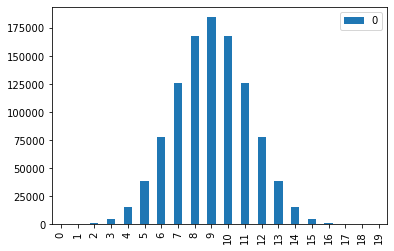

In [150]:
pd.DataFrame(fcs).plot.bar()

,mae,mape,mse,rmse
sell_buy_sent_ntusd_coms_wavg_,13.067981,56.292011,2.643107,16.257635
buy_sent_dbe_anger_sent_dbe_fear_,13.832649,34.696522,2.777517,16.665884
sell_buy_sent_lr_coms_,13.197925,61.728062,2.864207,16.923968
sell_buy_sent_dbe_fear_,13.851349,123.136977,2.869330,16.939098
buy_sent_ntusd_coms_wavg_sent_dbe_love_,13.224147,47.398782,2.875353,16.956865
...,...,...,...,...
sent_dbe_sadness_,20.838011,58.056275,10.420252,32.280415
sent_lr_,20.484879,54.735374,10.432899,32.299998
sent_db_sent_dbe_fear_,21.322269,54.985301,10.515929,32.428272
sent_db_,21.049859,52.661885,10.618175,32.585541


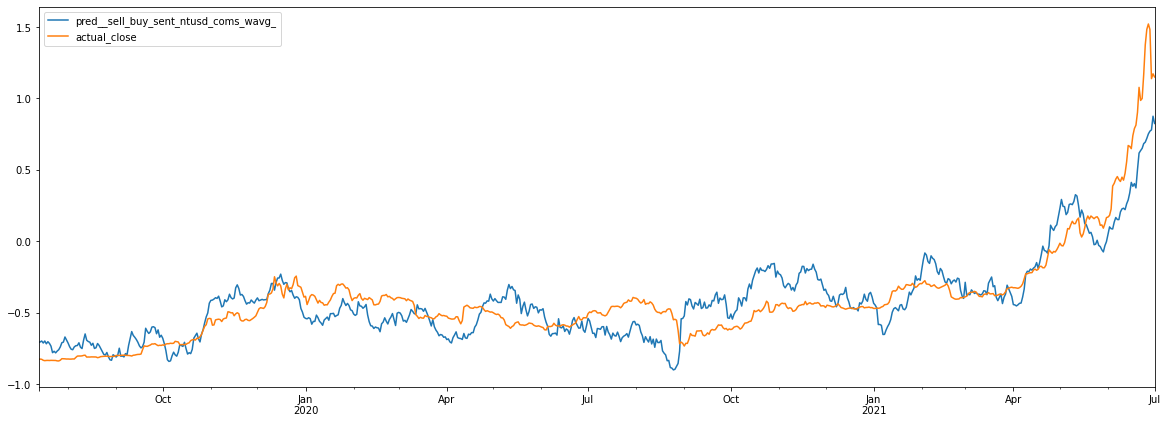

In [97]:
topcomb=pd.DataFrame(eval_res.T.sort_values(by='rmse').drop(columns=['me'])).index[0]
predictions[['pred__'+f'{topcomb}',f'actual_{TARGET}']].plot(figsize=(20,7))
pd.DataFrame(eval_res.T.sort_values(by='rmse').drop(columns=['me'])).iloc[:]*100

In [13]:
#predictions.plot(figsize=(25,35),subplots=True,layout=(10,3));
for col in predictions.columns:
    pass
    #if col!=f'actual_{TARGET}':predictions[[col,f'actual_{TARGET}']].plot(figsize=(20,7))

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_params={
    'n_neighbors':np.arange(10)+1,
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}

gs=GridSearchCV(
    KNeighborsRegressor(),
    grid_params,
    verbose=True,
    cv=3,
    n_jobs=-1
)

gsres=gs.fit(xt,yt)

res=pd.concat([pd.DataFrame(gsres.predict(xv),columns=['prediction']),pd.DataFrame(yv,columns=['actual'])],axis=1)
res.plot(figsize=(15,10))
evaluate_pred(res['prediction'],res['actual'])

# LSTM

In [31]:
# univariate lstm example
from numpy import array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Input

In [181]:
TARGET='close'
target=dft[TARGET]
#features=dft.drop(columns=[TARGET])
features=dft[['high','difference','buy','sent_lr_coms','volume']]
dt_index=dft.index
featuresnp=features.to_numpy()
targetnp=target.to_numpy()

count=0
train_window=4
test_window=1
test_lenght=30*1*1
x=[]
y=[]
for i in range(target.shape[0]-train_window-test_window):
    x.append(featuresnp[i:train_window+i])
    y.append(targetnp[train_window+i:train_window+i+test_window])

x=np.array(x)
y=np.array(y)

#x=x.reshape(-1,4*24)
#x=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
#y=y.reshape(y.shape[0],)
xt,xv=x[:-test_lenght],x[-test_lenght:]
yt,yv=y[:-test_lenght],y[-test_lenght:]


In [183]:

# define model
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', input_shape=(x.shape[1], x.shape[2],),return_sequences=False)))
#model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(x.shape[1],),return_sequences=True)))
#model.add(Bidirectional(LSTM(64, activation='relu',return_sequences=False)))
#model.add(Bidirectional(LSTM(128, activation='relu',return_sequences=False)))
#model.add(Bidirectional(LSTM(64, activation='relu')))
model.add(Dense(12))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mape')


In [184]:
# fit model
#xt = xt.reshape(xt.shape[0],xt.shape[1],1)

model.fit(xt, yt, epochs=50, batch_size=16, verbose=1)


Train on 877 samples
Epoch 1/50
877/877 [==============================] - 8s 9ms/sample - loss: 33.5576
Epoch 2/50
877/877 [==============================] - 2s 2ms/sample - loss: 15.9202
Epoch 3/50
877/877 [==============================] - 2s 2ms/sample - loss: 8.1091 0s 
Epoch 4/50
877/877 [==============================] - 2s 2ms/sample - loss: 12.2336
Epoch 5/50
877/877 [==============================] - 1s 2ms/sample - loss: 6.7993 0s - loss: 6.85
Epoch 6/50
877/877 [==============================] - 2s 2ms/sample - loss: 7.0835
Epoch 7/50
877/877 [==============================] - 2s 2ms/sample - loss: 6.3507
Epoch 8/50
877/877 [==============================] - 1s 2ms/sample - loss: 5.9823
Epoch 9/50
877/877 [==============================] - 2s 2ms/sample - loss: 8.3013
Epoch 10/50
877/877 [==============================] - 2s 2ms/sample - loss: 5.2233
Epoch 11/50
877/877 [==============================] - 1s 2ms/sample - loss: 6.1760
Epoch 12/50
877/877 [====================

30/30 [==============================] - 2s 75ms/sample


,knn
me,4.527474
mae,6.511329
mape,5.705585
mse,0.640367
rmse,8.002294


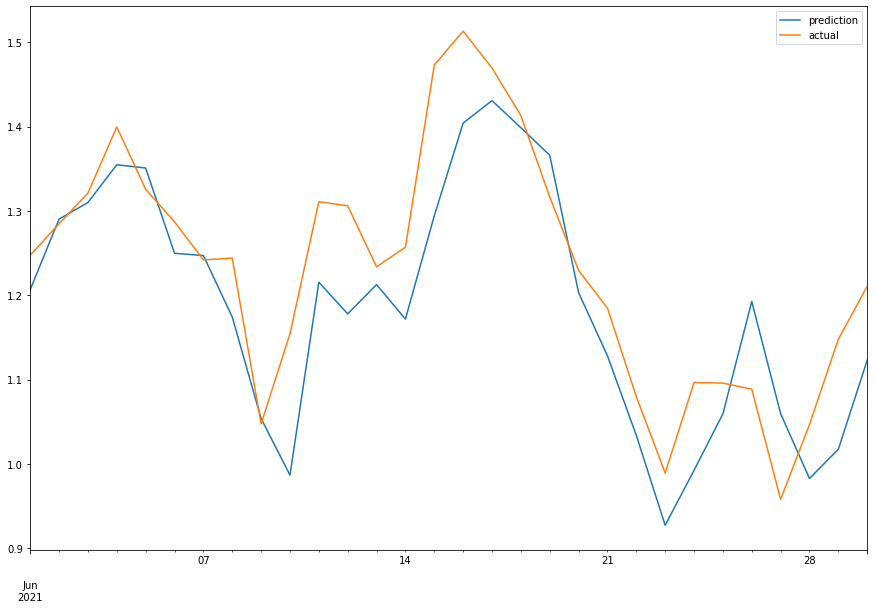

In [185]:
# demonstrate prediction
#xv = xv.reshape(xv.shape[0],xv.shape[1],1)
pred = model.predict(xv, verbose=1)

res=pd.concat(
    [
    pd.DataFrame(
        pred,
        columns=['prediction'],
        index=dt_index[-len(pred):]
        ),
    pd.DataFrame(
        yv,
        columns=['actual'],
        index=dt_index[-len(pred):]
        )
    ]
    ,axis=1)
res.plot(figsize=(15,10));
evaluate_pred(res['prediction'],res['actual'],model_name='knn')*100

In [163]:
eval.get_granger_causality(res)

,Y_actual__X_prediction,Y_prediction__X_actual
0,0.9343,0.0
1,0.0189,0.0
2,0.3016,0.0
3,0.5341,0.0
